In [ ]:
# # This Python 3 environment comes with many helpful analytics libraries installed
# # It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# # For example, here's several helpful packages to load

# import numpy as np # linear algebra
# import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# # Input data files are available in the read-only "../input/" directory
# # For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# # You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# # You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [1]:
from datasets import load_dataset
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments
from sklearn.model_selection import train_test_split
import torch
import re
import nltk
from nltk.corpus import stopwords

In [2]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [3]:
from datasets import load_dataset

# Load the dataset
dataset = load_dataset("Jinyan1/COLING_2025_MGT_multingual")

# Access the training and development splits
train_data = dataset['train']
dev_data = dataset['dev']

# Display the first example from the training set
print(train_data)
print(dev_data)

README.md:   0%|          | 0.00/589 [00:00<?, ?B/s]

train-00000-of-00003.parquet:   0%|          | 0.00/213M [00:00<?, ?B/s]

train-00001-of-00003.parquet:   0%|          | 0.00/213M [00:00<?, ?B/s]

train-00002-of-00003.parquet:   0%|          | 0.00/212M [00:00<?, ?B/s]

dev-00000-of-00001.parquet:   0%|          | 0.00/275M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/674083 [00:00<?, ? examples/s]

Generating dev split:   0%|          | 0/288894 [00:00<?, ? examples/s]

Dataset({
    features: ['id', 'source', 'sub_source', 'lang', 'model', 'label', 'text'],
    num_rows: 674083
})
Dataset({
    features: ['id', 'source', 'sub_source', 'lang', 'model', 'label', 'text'],
    num_rows: 288894
})


In [4]:
from collections import Counter

# Count occurrences in the 'lang' column
lang_counts = Counter(train_data['lang'])

# Display the value counts for the 'lang' column
print("Language Value Counts:")
for lang, count in lang_counts.items():
    print(f"{lang}: {count}")

Language Value Counts:
en: 610676
zh: 35284
de: 4693
id: 3976
it: 4174
bg: 8091
ar: 2114
ur: 3761
ru: 1314


In [5]:
# Count occurrences in the 'label' column
label_counts = Counter(train_data['label'])

# Display the value counts for the 'label' column
print("Language Value Counts:")
for label, count in label_counts.items():
    print(f"{label}: {count}")

Language Value Counts:
1: 416115
0: 257968


In [6]:
# Convert the train split to a Pandas DataFrame
train_data = dataset['train'].to_pandas()

# Function to sample based on language
def sample_data(group):
    if group.name in ['en', 'zh']:
        return group.sample(n=min(10000, len(group)), random_state=42)
    else:
        return group

# Group by 'lang' and apply the sampling function
sampled_data = train_data.groupby('lang').apply(sample_data).reset_index(drop=True)

# Display the resulting dataset
print("Sampled Dataset:")
print(sampled_data)

# Save the sampled dataset (optional)
sampled_data.to_csv("sampled_dataset.csv", index=False)


/tmp/ipykernel_30/1168841790.py:12: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  sampled_data = train_data.groupby('lang').apply(sample_data).reset_index(drop=True)


Sampled Dataset:
                                         id source      sub_source lang  \
0      374c60d2-dd43-4b61-9ea1-d1a8fa309624   m4gt  News/Wikipedia   ar   
1      a4e44d93-be72-41ca-84b9-b3e83ecf46ed   m4gt  News/Wikipedia   ar   
2      ff3bfdb9-5f8c-4315-93c6-28e200fa5892   m4gt  News/Wikipedia   ar   
3      ac907968-8c7b-4493-bb0e-feed48581588   m4gt  News/Wikipedia   ar   
4      2bcbb1c1-c5d9-42e8-9fe5-281d8d0edf0a   m4gt  News/Wikipedia   ar   
...                                     ...    ...             ...  ...   
48118  7b400ccb-cf66-4c6e-b1f5-22867bc5cf1e    hc3         open_qa   zh   
48119  6d0a0aea-54c9-411c-8372-ef6d209accc8    hc3         open_qa   zh   
48120  3e3f8314-95b8-45a8-9bbf-78814de27989    hc3      psychology   zh   
48121  99f39274-481e-43b7-b7ec-e9209823d5c1   m4gt    Baike/Web QA   zh   
48122  12cb11db-156c-481a-acc7-fe6622d8a725    hc3      nlpcc_dbqa   zh   

               model  label                                               text  
0

In [7]:
sampled_data.head()

,id,source,sub_source,lang,model,label,text
0,374c60d2-dd43-4b61-9ea1-d1a8fa309624,m4gt,News/Wikipedia,ar,gpt-3.5-turbo,1,أشعل اغتيال قائد فيلق القدس في الحرس الثوري ال...
1,a4e44d93-be72-41ca-84b9-b3e83ecf46ed,m4gt,News/Wikipedia,ar,gpt-3.5-turbo,1,في محاولة لكسب دعم الناخبين الإنجيليين في الان...
2,ff3bfdb9-5f8c-4315-93c6-28e200fa5892,m4gt,News/Wikipedia,ar,gpt-3.5-turbo,1,جبال الأبالاش (بالإنجليزية: Appalachian Mounta...
3,ac907968-8c7b-4493-bb0e-feed48581588,m4gt,News/Wikipedia,ar,gpt-3.5-turbo,1,أكدت مصادر أمنية مصرية أن الجهات الأمنية التاب...
4,2bcbb1c1-c5d9-42e8-9fe5-281d8d0edf0a,m4gt,News/Wikipedia,ar,gpt-3.5-turbo,1,أكدت الكويت رفضها التام لاستخدام أراضيها في أي...


In [8]:
sampled_data["lang"].value_counts()

lang
en    10000
zh    10000
bg     8091
de     4693
it     4174
id     3976
ur     3761
ar     2114
ru     1314
Name: count, dtype: int64

In [9]:
df = sampled_data

In [10]:
import re
from nltk.corpus import stopwords

# Load English stop words from NLTK
english_stopwords = set(stopwords.words('english'))

def preprocess_text_for_english_only(text, lang):
    """
    Preprocesses the text:
    - For English: Removes links, stop words, converts to lowercase, and removes special characters.
    - For other languages: Leaves text unchanged but removes rows containing links.
    """
    # Remove links for all languages
    if re.search(r'http[s]?://\S+', text):
        return None  # Mark rows with links for removal
    
    # Apply additional preprocessing for English language only
    if lang == "en":
        # Convert text to lowercase
        text = text.lower()
        
        # Remove special characters (keep only alphanumeric and spaces)
        text = re.sub(r'[^a-zA-Z\s]', '', text)
        
        # Tokenize and remove stop words
        words = text.split()
        filtered_words = [word for word in words if word not in english_stopwords]
        
        # Join the words back into a single string
        return ' '.join(filtered_words)
    
    # Return unchanged text for non-English languages
    return text

def preprocess_dataframe(df, text_column, lang_column):
    """
    Preprocesses the DataFrame:
    1. Removes rows with links in the specified text column.
    2. Applies text preprocessing to English rows only.
    """
    # Apply the preprocessing function to the text column
    df[text_column] = df.apply(
        lambda row: preprocess_text_for_english_only(row[text_column], row[lang_column]), axis=1
    )
    
    # Remove rows marked as None (i.e., rows with links)
    df = df.dropna(subset=[text_column]).reset_index(drop=True)
    
    return df


In [11]:
processed_df = preprocess_dataframe(df, "text", "lang")

In [12]:
processed_df.head()

,id,source,sub_source,lang,model,label,text
0,374c60d2-dd43-4b61-9ea1-d1a8fa309624,m4gt,News/Wikipedia,ar,gpt-3.5-turbo,1,أشعل اغتيال قائد فيلق القدس في الحرس الثوري ال...
1,a4e44d93-be72-41ca-84b9-b3e83ecf46ed,m4gt,News/Wikipedia,ar,gpt-3.5-turbo,1,في محاولة لكسب دعم الناخبين الإنجيليين في الان...
2,ff3bfdb9-5f8c-4315-93c6-28e200fa5892,m4gt,News/Wikipedia,ar,gpt-3.5-turbo,1,جبال الأبالاش (بالإنجليزية: Appalachian Mounta...
3,ac907968-8c7b-4493-bb0e-feed48581588,m4gt,News/Wikipedia,ar,gpt-3.5-turbo,1,أكدت مصادر أمنية مصرية أن الجهات الأمنية التاب...
4,2bcbb1c1-c5d9-42e8-9fe5-281d8d0edf0a,m4gt,News/Wikipedia,ar,gpt-3.5-turbo,1,أكدت الكويت رفضها التام لاستخدام أراضيها في أي...


In [13]:
df1 = processed_df.sample(frac=1, random_state=42).reset_index(drop=True)

In [14]:
x = df1['text']
y = df1['label']

In [15]:
pip install transformers==4.45.1 tensorflow==2.16.1

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


Note: you may need to restart the kernel to use updated packages.


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

Tokenizing data: 100%|██████████| 9537/9537 [01:01<00:00, 154.43it/s]


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

All PyTorch model weights were used when initializing TFBertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/3
Cause: for/else statement not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
2385/2385 [==============================] - 756s 291ms/step - loss: 0.4454 - accuracy: 0.7629 - val_loss: 0.3460 - val_accuracy: 0.8350
Epoch 2/3
2385/2385 [==============================] - 685s 287ms/step - loss: 0.2802 - accuracy: 0.8777 - val_loss: 0.3031 - val_accuracy: 0.8657
Epoch 3/3
299/299 [==============================] - 56s 163ms/step
Confusion Matrix:
[[2943  741]
 [ 426 5427]]

Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.80      0.83      3684
           1       0.88      0.93      0.90      5853

    accuracy                           0.88      9537
   macro avg       0.88      0.86      0.87      9537
weighted avg       0.88      0.88      0.88      9537



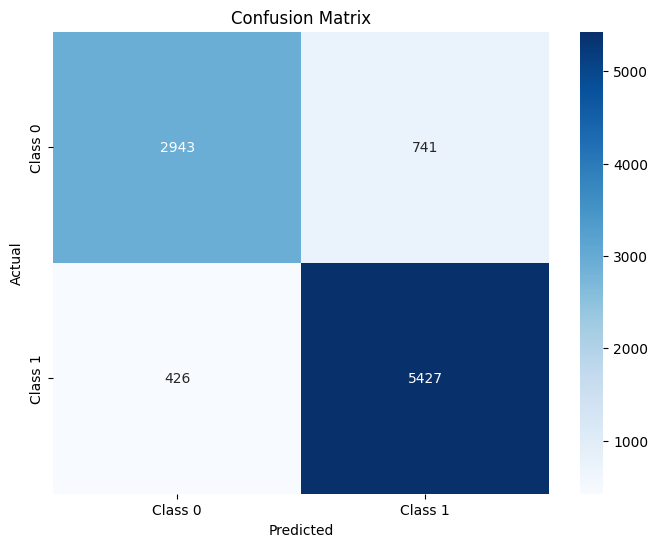

In [16]:
from sklearn.model_selection import train_test_split
from transformers import BertTokenizer, TFBertForSequenceClassification
from transformers import create_optimizer
from sklearn.metrics import confusion_matrix, classification_report
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

# Step 1: Data Preparation
# Assuming `df1` contains 'text' and 'label' columns
x = df1['text'].tolist()  # Convert text data to a list
y = df1['label'].tolist()  # Convert labels to a list

# Ensure there are no None or NaN values in x or y
x = [str(text) for text in x if text is not None]
y = [label for label in y if label is not None]

# Ensure y contains integer labels only (e.g., 0 and 1 for binary classification)
y = np.array(y, dtype=np.int32)

# Splitting the dataset
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

# Step 2: Tokenizer and Encoding
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
max_len = 128

# Tokenizing Data
def tokenize_data(texts, tokenizer, max_len):
    input_ids, attention_masks = [], []
    for text in tqdm(texts, desc="Tokenizing data"):
        encoding = tokenizer(
            text,
            truncation=True,
            padding="max_length",
            max_length=max_len,
            return_tensors="tf",
        )
        input_ids.append(encoding["input_ids"][0].numpy())
        attention_masks.append(encoding["attention_mask"][0].numpy())
    return np.array(input_ids), np.array(attention_masks)

# Tokenize the training and testing data
train_input_ids, train_attention_masks = tokenize_data(x_train, tokenizer, max_len)
test_input_ids, test_attention_masks = tokenize_data(x_test, tokenizer, max_len)

# Step 3: Model Definition
model = TFBertForSequenceClassification.from_pretrained(
    "bert-base-uncased", num_labels=2  # Adjust `num_labels` for your use case
)

# Define optimizer
batch_size = 16
epochs = 3
num_train_steps = (len(train_input_ids) // batch_size) * epochs
num_warmup_steps = int(0.1 * num_train_steps)  # 10% warmup

optimizer, schedule = create_optimizer(
    init_lr=5e-5,
    num_train_steps=num_train_steps,
    num_warmup_steps=num_warmup_steps,
    weight_decay_rate=0.01,
)

# Compile the model
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
model.compile(optimizer=optimizer, loss=loss, metrics=["accuracy"])

# Step 4: Train the Model
history = model.fit(
    {"input_ids": train_input_ids, "attention_mask": train_attention_masks},
    y_train,
    validation_data=(
        {"input_ids": test_input_ids, "attention_mask": test_attention_masks},
        y_test,
    ),
    epochs=epochs,
    batch_size=batch_size,
)

# Step 5: Prediction Logic
def predict_texts(texts, model, tokenizer, max_len):
    encodings = tokenizer(
        texts,
        truncation=True,
        padding="max_length",
        max_length=max_len,
        return_tensors="tf",
    )
    predictions = model.predict(
        {"input_ids": encodings["input_ids"], "attention_mask": encodings["attention_mask"]}
    )
    return np.argmax(predictions.logits, axis=1)

y_pred = predict_texts(x_test, model, tokenizer, max_len)

# Confusion Matrix and Report
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)

print("Confusion Matrix:")
print(conf_matrix)
print("\nClassification Report:")
print(class_report)

# Visualizing Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(
    conf_matrix,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=["Class 0", "Class 1"],
    yticklabels=["Class 0", "Class 1"],
)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


In [17]:
import os
import shutil
from transformers import BertTokenizer, TFBertForSequenceClassification

# Define directories for saving model and tokenizer
base_directory = "./saved_files"
model_save_directory = os.path.join(base_directory, "model")
tokenizer_save_directory = os.path.join(base_directory, "tokenizer")

# Ensure base directory exists
os.makedirs(base_directory, exist_ok=True)

# Save the model and tokenizer in their respective directories
os.makedirs(model_save_directory, exist_ok=True)
os.makedirs(tokenizer_save_directory, exist_ok=True)

# Save the model to its directory
model.save_pretrained(model_save_directory)

# Save the tokenizer to its directory
tokenizer.save_pretrained(tokenizer_save_directory)

print(f"Model saved to {model_save_directory}")
print(f"Tokenizer saved to {tokenizer_save_directory}")


Model saved to ./saved_files/model
Tokenizer saved to ./saved_files/tokenizer
